In [109]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
import theano
import xgboost as xgb
import gc


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [110]:
ls

data/  forexeda.ipynb  getdata/  models/  README.md  resources/  trash/


In [111]:
who

AdaBoostClassifier	 DecisionTreeClassifier	 Dense	 GradientBoostingClassifier	 GridSearchCV	 HTML	 KFold	 LogisticRegression	 MaxAbsScaler	 
MinMaxScaler	 PCA	 RandomForestClassifier	 RobustScaler	 SGD	 SVC	 Sequential	 StandardScaler	 TSNE	 
TimeSeriesSplit	 accuracy_score	 ad	 auc	 ax	 axes	 classer	 classer_name	 classification_report	 
clf	 close_prices	 close_prices_scaled	 col	 col_name	 cross_val_score	 cum_returns	 cyc_ind	 d_test	 
d_train	 datetime	 df	 df_columns	 display	 drop_columns	 dt	 feat_impor	 fig	 
fpr	 fun	 gb	 gc	 i	 lr	 ma	 make_pipeline	 mm	 
mod	 mod_col	 mod_name	 model	 model_list	 model_returns	 models	 mom_cols	 mom_ind	 
mom_time	 np	 np_utils	 num_classes	 num_inputs	 num_neurons_in_layer	 ohlcv	 over_stud	 pca	 
pd	 per	 plot_price	 plt	 precision_score	 predict_columns	 predict_df_cols	 prediction_df	 probas	 
re	 recall_score	 res	 return_types	 returns	 rf	 roc_auc	 roc_curve	 rs	 
sc	 scale	 scalers	 scs	 sns	 split_index	 ss	 talib	 talib_abstract_

# Get Data

In [112]:
df = pd.read_pickle('data/EUR_USD_M1')
df.set_index('time', inplace=True)
df.shape
df_columns = list(df.columns)

In [113]:
df.head()

,volume,close,high,low,open,complete
time,,,,,,
2005-01-02 18:29:00,1,1.356000,1.356000,1.356000,1.356000,True
2005-01-02 18:38:00,1,1.356000,1.356000,1.356000,1.356000,True
2005-01-02 18:51:00,1,1.356700,1.356700,1.356700,1.356700,True
2005-01-02 18:52:00,1,1.356500,1.356500,1.356500,1.356500,True
2005-01-02 18:55:00,1,1.356800,1.356800,1.356800,1.356800,True


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4644072 entries, 2005-01-02 18:29:00 to 2017-09-05 03:34:00
Data columns (total 6 columns):
volume      int64
close       float64
high        float64
low         float64
open        float64
complete    bool
dtypes: bool(1), float64(4), int64(1)
memory usage: 217.0 MB


In [115]:
def plot_price(price_series, figtitle):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(price_series)
    ax.set_title(figtitle)    

In [116]:
df = df.loc[datetime(2016,4,1):datetime(2016,6,1)]
df.shape

(58405, 6)

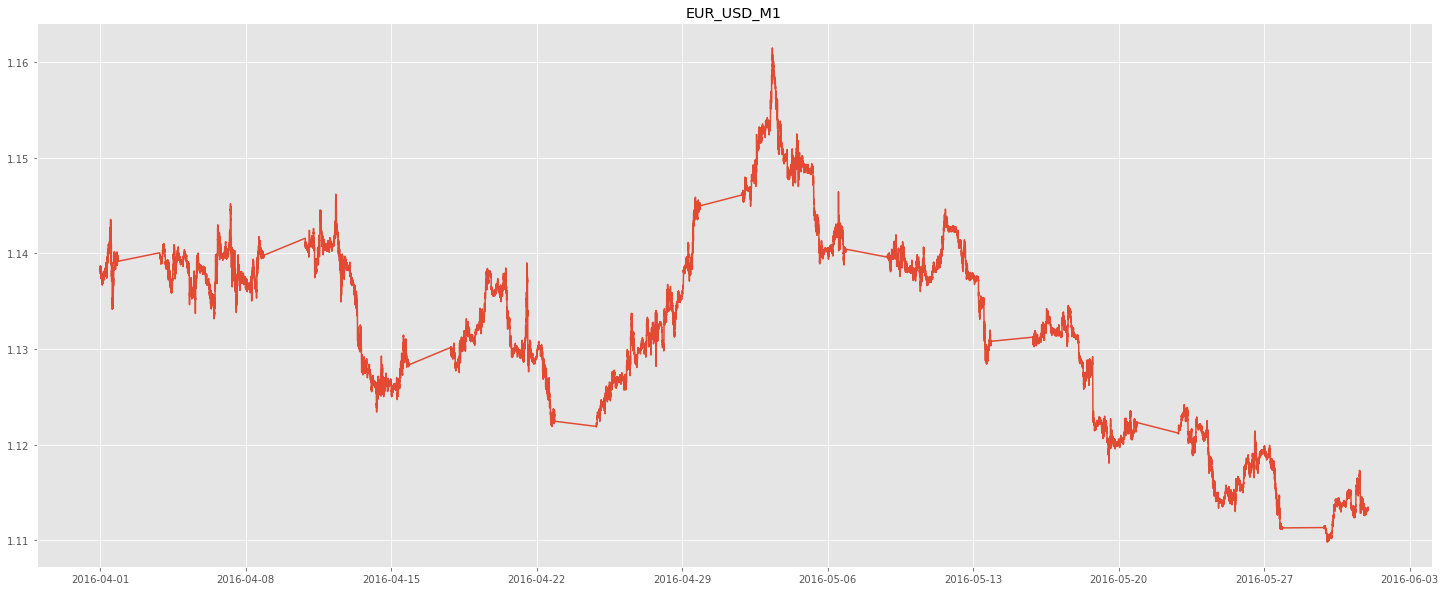

In [117]:
plot_price(df['close'], 'EUR_USD_M1')

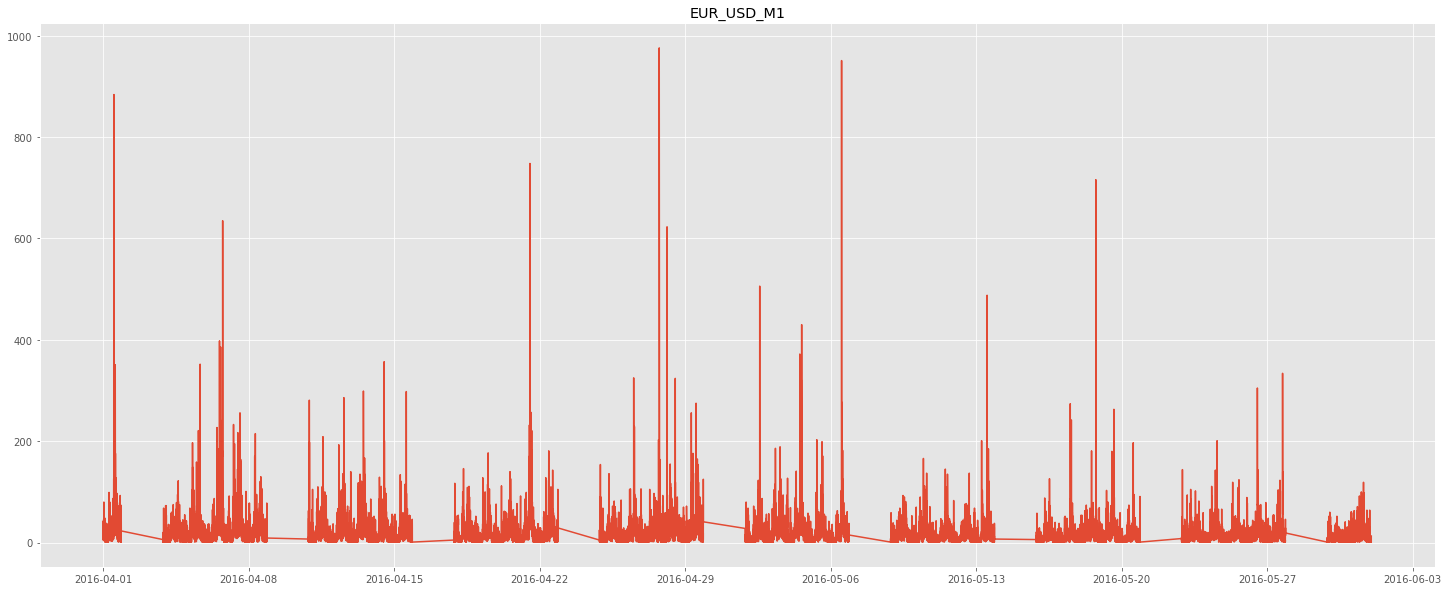

In [118]:
plot_price(df['volume'], 'EUR_USD_M1')

In [119]:
close_prices = df['close'].values.reshape(-1,1)
close_prices.shape

(58405, 1)

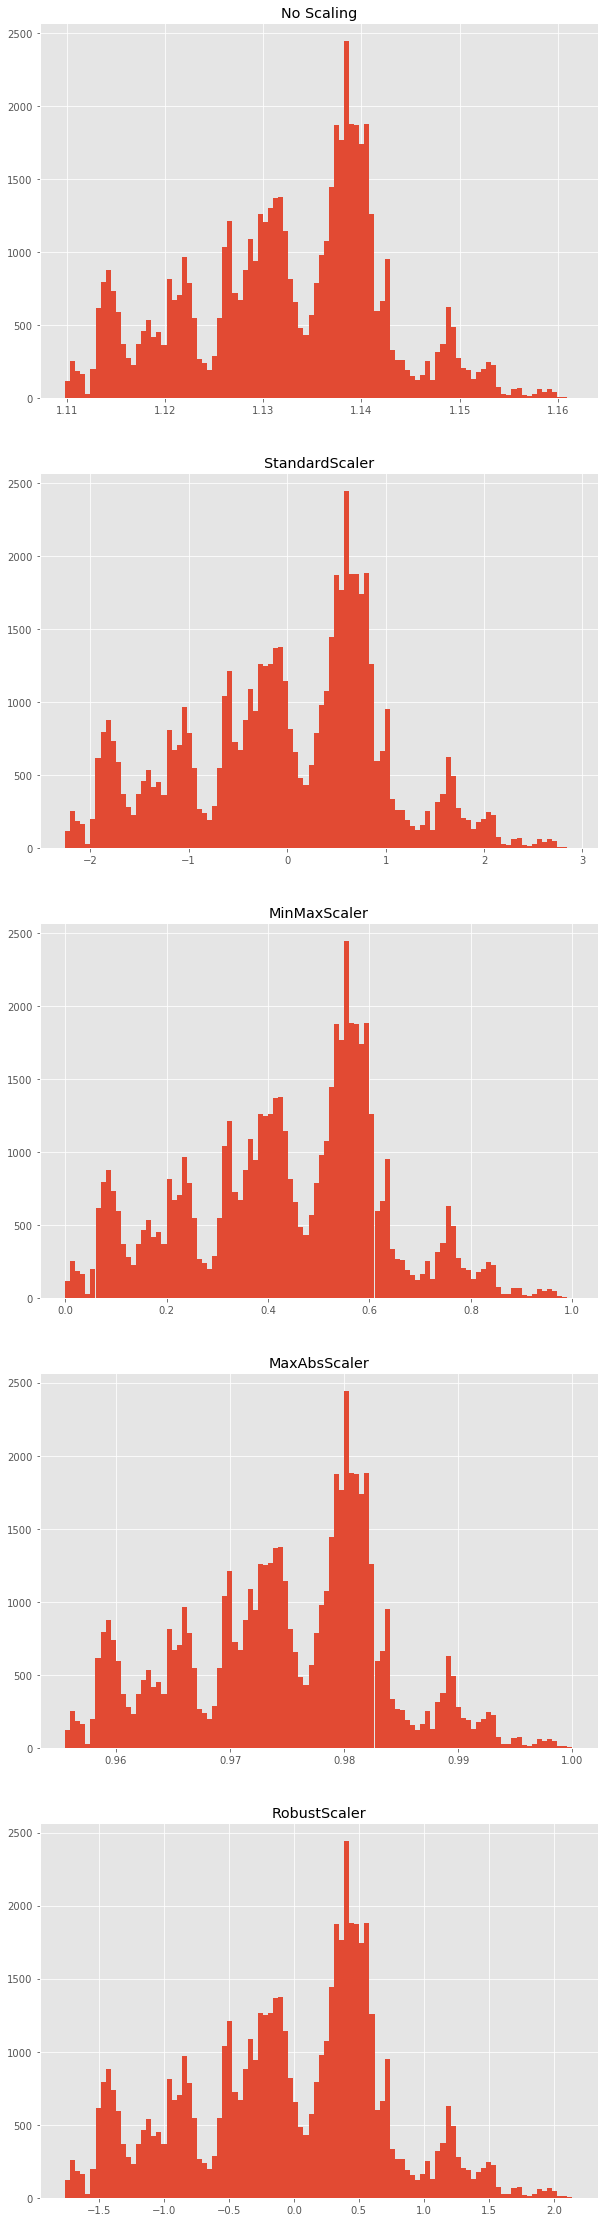

In [120]:
sc, mm, ma, rs = StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()
scalers = [sc, mm, ma, rs]
fig, axes = plt.subplots(len(scalers)+1, 1, figsize=(10,40))
for i, ax in enumerate(axes.reshape(-1)):
    if i == 0:
        ax.hist(close_prices, bins=100)
        ax.set_title('No Scaling')
    else:
        scale = scalers[i-1]
        close_prices_scaled = scale.fit_transform(close_prices)
        ax.hist(close_prices_scaled, bins=100)
        ax.set_title(scale.__class__.__name__)

In [121]:
df_columns = list(df.columns)

# Add Target for Classification (Up / Down)

target of i day is the np.sign((open i+d) - (open i))

Exponentially smooth data before calculating features?

In [122]:
# df = pd.read_pickle('data/EUR_USD_H12')
# df.set_index('time', inplace=True)
# df.shape
# df.head()

In [123]:
def up_down(row):
    if row >= 0:
        return 1
    elif row < 0:
        return 0
    else:
        None

In [124]:
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['ari_returns'] = (df['close'] / df['close'].shift(1)) - 1
df['log_returns_shifted'] = np.log(df['close'].shift(-1) / df['close'])
df['target_label_direction'] = df['log_returns'].apply(up_down)
df['target_label_direction_shifted'] = df['log_returns_shifted'].apply(up_down)

In [125]:
df.head(100)

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
time,,,,,,,,,,,
2016-04-01 00:00:00,29,1.137920,1.137960,1.137680,1.137860,True,nan,nan,0.000097,nan,1.000000
2016-04-01 00:01:00,16,1.138030,1.138030,1.137800,1.137880,True,0.000097,0.000097,0.000132,1.000000,1.000000
2016-04-01 00:02:00,11,1.138180,1.138210,1.138040,1.138060,True,0.000132,0.000132,0.000000,1.000000,1.000000
2016-04-01 00:03:00,15,1.138180,1.138230,1.138130,1.138160,True,0.000000,0.000000,0.000000,1.000000,1.000000
2016-04-01 00:04:00,8,1.138180,1.138200,1.138140,1.138180,True,0.000000,0.000000,0.000123,1.000000,1.000000
2016-04-01 00:05:00,4,1.138320,1.138320,1.138220,1.138220,True,0.000123,0.000123,-0.000018,1.000000,0.000000
2016-04-01 00:06:00,14,1.138300,1.138300,1.138220,1.138280,True,-0.000018,-0.000018,-0.000018,0.000000,0.000000
2016-04-01 00:07:00,10,1.138280,1.138340,1.138270,1.138340,True,-0.000018,-0.000018,0.000325,0.000000,1.000000
2016-04-01 00:08:00,42,1.138650,1.138720,1.138320,1.138320,True,0.000325,0.000325,0.000026,1.000000,1.000000


In [126]:
np.log(1.34455/1.35525)

-0.0079265545770773362

In [127]:
df.tail()

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
time,,,,,,,,,,,
2016-05-31 23:56:00,2,1.113390,1.113400,1.113390,1.113400,True,0.000009,0.000009,0.000045,1.000000,1.000000
2016-05-31 23:57:00,2,1.113440,1.113440,1.113410,1.113410,True,0.000045,0.000045,-0.000009,1.000000,0.000000
2016-05-31 23:58:00,4,1.113430,1.113490,1.113430,1.113460,True,-0.000009,-0.000009,-0.000027,0.000000,0.000000
2016-05-31 23:59:00,1,1.113400,1.113400,1.113400,1.113400,True,-0.000027,-0.000027,0.000045,0.000000,1.000000
2016-06-01 00:00:00,13,1.113450,1.113460,1.113340,1.113370,True,0.000045,0.000045,nan,1.000000,nan


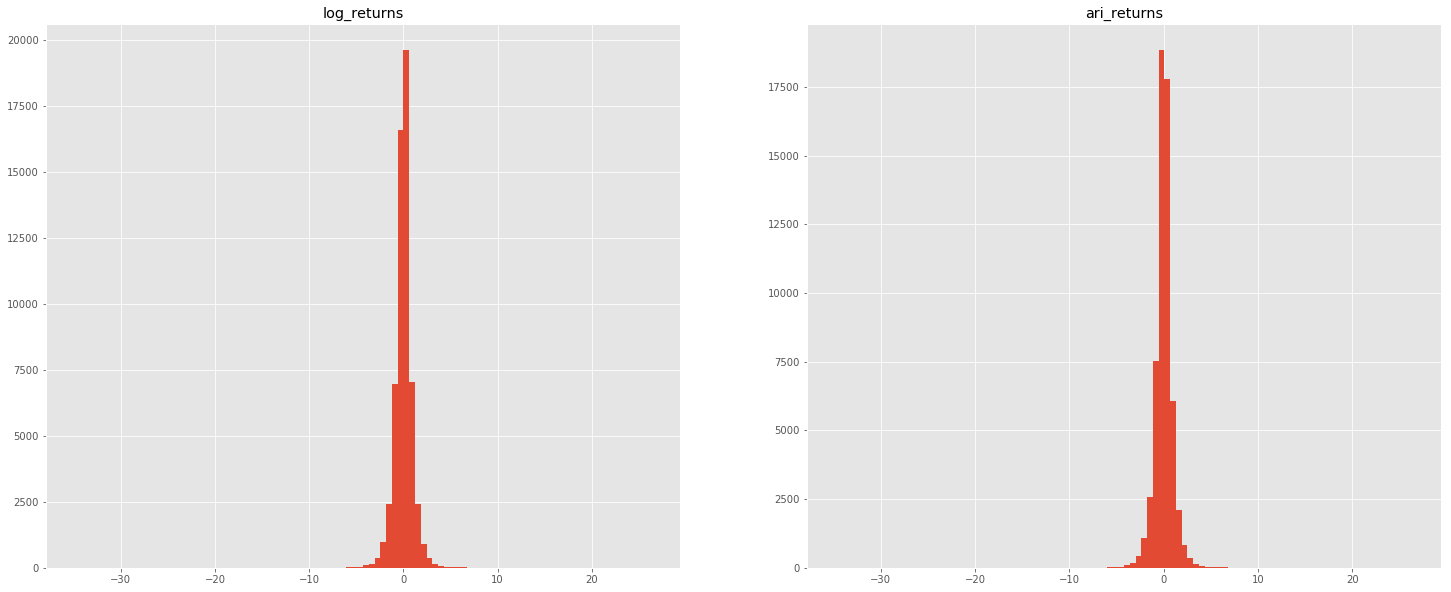

In [128]:
return_types = ['log_returns', 'ari_returns']
fig, axes = plt.subplots(1, len(return_types), figsize=(25,10))
for i, ax in enumerate(axes.reshape(-1)):
    returns = df[return_types[i]].dropna().values.reshape(-1,1)
    returns = StandardScaler().fit_transform(returns)
    ax.hist(returns, bins=100)
    ax.set_title(return_types[i])
plt.show()

# Scale

In [129]:
df.describe()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
count,58405.000000,58405.000000,58405.000000,58405.000000,58405.000000,58404.000000,58404.000000,58404.000000,58404.000000,58404.000000
mean,18.814228,1.132434,1.132514,1.132354,1.132435,-0.000000,-0.000000,-0.000000,0.525666,0.525666
std,25.692400,0.010020,0.010029,0.010013,0.010021,0.000138,0.000138,0.000138,0.499345,0.499345
min,1.000000,1.109820,1.109900,1.109800,1.109820,-0.004828,-0.004816,-0.004828,0.000000,0.000000
25%,6.000000,1.126120,1.126200,1.126040,1.126120,-0.000061,-0.000061,-0.000061,0.000000,0.000000
50%,12.000000,1.133120,1.133240,1.133020,1.133130,0.000000,0.000000,0.000000,1.000000,1.000000
75%,24.000000,1.139350,1.139450,1.139260,1.139360,0.000054,0.000054,0.000054,1.000000,1.000000
max,976.000000,1.161470,1.161640,1.160780,1.161430,0.003641,0.003648,0.003641,1.000000,1.000000


In [130]:
df.drop('complete', axis=1, inplace=True)

In [131]:
# scale_columns = ['volume', 'close', 'high', 'low', 'open',]
# mm = MinMaxScaler()
# scale_values = mm.fit_transform(df[scale_columns])
# df[scale_columns] = scale_values
# df.describe()

In [132]:
df.head()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
time,,,,,,,,,,
2016-04-01 00:00:00,29,1.137920,1.137960,1.137680,1.137860,nan,nan,0.000097,nan,1.000000
2016-04-01 00:01:00,16,1.138030,1.138030,1.137800,1.137880,0.000097,0.000097,0.000132,1.000000,1.000000
2016-04-01 00:02:00,11,1.138180,1.138210,1.138040,1.138060,0.000132,0.000132,0.000000,1.000000,1.000000
2016-04-01 00:03:00,15,1.138180,1.138230,1.138130,1.138160,0.000000,0.000000,0.000000,1.000000,1.000000
2016-04-01 00:04:00,8,1.138180,1.138200,1.138140,1.138180,0.000000,0.000000,0.000123,1.000000,1.000000


# Add Features pandas

In [133]:
# df['20d_ma'] = df['close'].rolling(window=20).mean()
# df['50d_ma'] = df['close'].rolling(window=50).mean()
# df['Bol_upper'] = df['close'].rolling(window=20).mean() + 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_lower'] = df['close'].rolling(window=20).mean() - 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_BW'] = ((df['Bol_upper'] - df['Bol_lower'])/df['20d_ma'])*100
# df['Bol_BW_200MA'] = df['Bol_BW'].rolling(window=50).mean()
# df['20d_exma'] = df['close'].ewm(span=20).mean()
# df['50d_exma'] = df['close'].ewm(span=50).mean()

In [134]:
# df.plot(y=['close','20d_ma','50d_ma','Bol_upper','Bol_lower'], figsize=(25,10))

In [135]:
# df.plot(y=['close', '20d_exma','50d_exma'], figsize=(25,10))

In [136]:
# df.plot(y=['Bol_BW','Bol_BW_200MA'], figsize=(25,10))

# Add Features TA-Lib

In [137]:
print(talib.get_function_groups().keys())
print(talib.get_functions())
#talib.abstract.__all__

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])
['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', '

In [138]:
mom_ind = talib.get_function_groups()['Momentum Indicators']
over_stud = talib.get_function_groups()['Overlap Studies']
volu_ind = talib.get_function_groups()['Volume Indicators']
cyc_ind = talib.get_function_groups()['Cycle Indicators']
vola_ind = talib.get_function_groups()['Volatility Indicators']
talib_abstract_fun_list = mom_ind + over_stud + volu_ind + cyc_ind + vola_ind
# talib_abstract_fun_list = talib.abstract.__all__[1:]
# talib_abstract_fun_list = ['RSI', 'STOCH', 'WILLR', 'ATR', 'MACD']
print(talib_abstract_fun_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE']


In [139]:
talib_abstract_fun_list = [i for i in talib_abstract_fun_list if i not in ['MAVP','ASIN', 'ACOS']]
print(len(talib_abstract_fun_list))

57


In [140]:
print(talib_abstract_fun_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE']


In [141]:
ohlcv = {
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'volume': df['volume'].astype(float)
}

In [142]:
for fun in talib_abstract_fun_list:
    res = getattr(talib.abstract, fun)(ohlcv)
    if len(res) > 10:
        df[fun] = res
    else:
        for i, val in enumerate(res):
            df[fun+'_'+str(i+1)] = val

In [143]:
for per in [3,6,12,18,25, 30]:
    col_name = 'MAVP_'+str(per)
    df[col_name] = talib.MAVP(df['close'].values, periods=np.array([float(per)]*df.shape[0]))

In [144]:
df.head(100)

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,ADX,ADXR,APO,AROON_1,AROON_2,AROONOSC,BOP,CCI,CMO,DX,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,TRIX,ULTOSC,WILLR,BBANDS_1,BBANDS_2,BBANDS_3,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MAMA_1,MAMA_2,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,AD,ADOSC,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,ATR,NATR,TRANGE,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25,MAVP_30
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 00:00:00,29,1.137920,1.137960,1.137680,1.137860,nan,nan,0.000097,nan,1.000000,nan,nan,nan,nan,nan,nan,0.214286,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.714286,nan,29.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-04-01 00:01:00,16,1.138030,1.138030,1.137800,1.137880,0.000097,0.000097,0.000132,1.000000,1.000000,nan,nan,nan,nan,nan,nan,0.652174,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.137680,1.137680,nan,nan,nan,nan,nan,36.714286,nan,45.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,0.000230,nan,nan,nan,nan,nan,nan
2016-04-01 00:02:00,11,1.138180,1.138210,1.138040,1.138060,0.000132,0.000132,0.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,0.705882,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.137687,1.137687,nan,nan,nan,nan,nan,43.831933,nan,56.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,0.000180,nan,nan,nan,nan,nan,nan
2016-04-01 00:03:00,15,1.138180,1.138230,1.138130,1.138160,0.000000,0.000000,0.000000,1.000000,1.000000,nan,nan,nan,nan,nan,nan,0.200000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.137708,1.137708,nan,nan,nan,nan,nan,43.831933,nan,56.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,0.000100,nan,nan,nan,nan,nan,nan
2016-04-01 00:04:00,8,1.138180,1.138200,1.138140,1.138180,0.000000,0.000000,0.000123,1.000000,1.000000,nan,nan,nan,nan,nan,nan,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.138311,1.138098,1.137885,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.137739,1.137739,nan,nan,nan,nan,nan,46.498599,nan,56.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,0.000060,nan,nan,nan,nan,nan,nan
2016-04-01 00:05:00,4,1.138320,1.138320,1.138220,1.138220,0.000123,0.000123,-0.000018,1.000000,0.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.138178,1.138178,1.138178,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.137769,1.137769,nan,nan,nan,nan,nan,50.498599,nan,60.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,0.000140,nan,nan,nan,nan,nan,nan
2016-04-01 00:06:00,14,1.138300,1.138300,1.138220,1.138280,-0.000018,-0.000018,-0.000018,0.000000,0.000000,nan,nan,nan,nan,nan,nan,0.250000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,92.857143,94.588745,nan,nan,nan,nan,nan,1.138232,1.138232,1.138232,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.137813,1.137813,nan,nan,nan,nan,nan,64.498599,nan,46.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,0.000100,nan,nan,nan,nan,nan,nan
2016-04-01 00:07:00,10,1.138280,1.138340,1.138270,1.138340,-0.000018,-0.0

In [145]:
df.columns

Index(['volume', 'close', 'high', 'low', 'open', 'log_returns', 'ari_returns',
       'log_returns_shifted', 'target_label_direction',
       'target_label_direction_shifted', 'ADX', 'ADXR', 'APO', 'AROON_1',
       'AROON_2', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD_1', 'MACD_2',
       'MACD_3', 'MACDEXT_1', 'MACDEXT_2', 'MACDEXT_3', 'MACDFIX_1',
       'MACDFIX_2', 'MACDFIX_3', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM',
       'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI',
       'STOCH_1', 'STOCH_2', 'STOCHF_1', 'STOCHF_2', 'STOCHRSI_1',
       'STOCHRSI_2', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS_1', 'BBANDS_2',
       'BBANDS_3', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_1',
       'MAMA_2', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA',
       'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE',
       'HT_PHASOR_1', 'HT_PHASOR_2', 'HT_SINE_1', 'HT_SINE_2', 'HT_TRENDMODE',
       'ATR', 'NATR', 'TRANGE', 'MAVP_3', 'MAVP_6', 

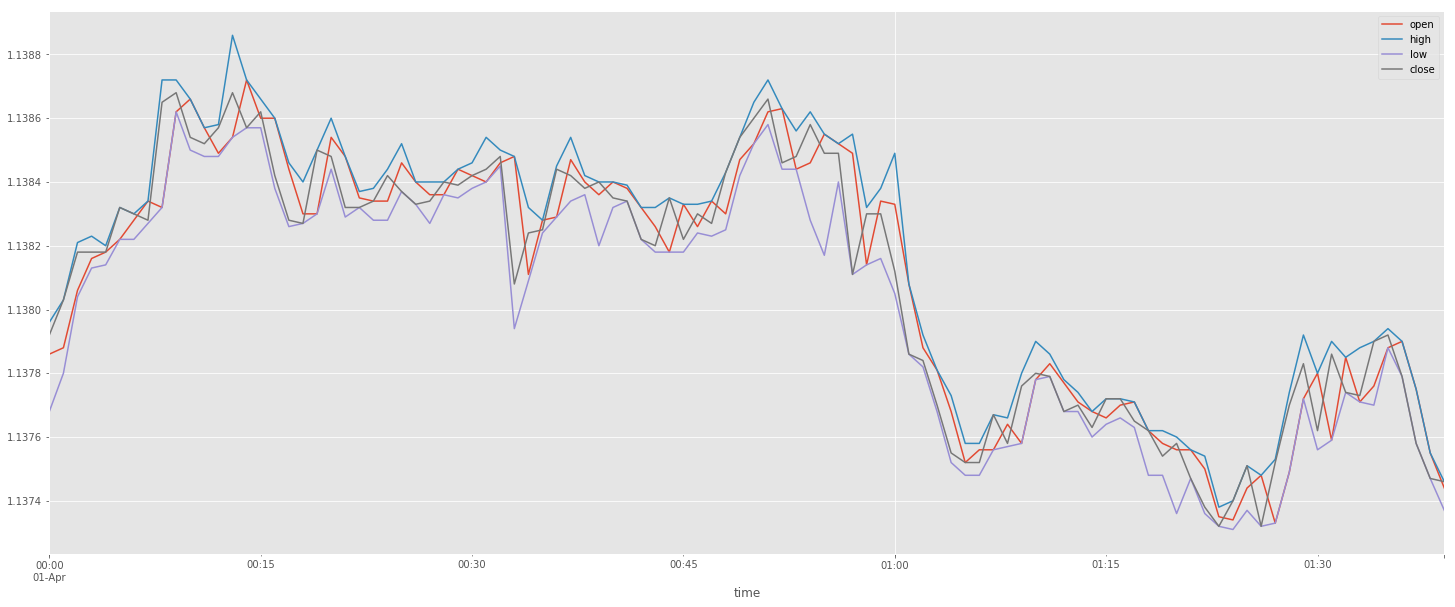

In [146]:
df.iloc[:100].plot(y=['open', 'high', 'low', 'close'], figsize=(25,10))

In [147]:
# for indi in df.columns:
#     df.plot(y=[indi], figsize=(25,10))

In [148]:
# df.iloc[:300].plot(y=['MAC'], figsize=(25,10))

In [149]:
# for col in df.columns:
#     if df[col].isnull().all():
#         print(col)
#         df.drop(col, axis=1, inplace=True)
# df.drop(['ASIN', 'ACOS'],axis=1, inplace=True)

In [150]:
df.shape[0] - df.dropna().shape[0]

89

In [151]:
drop_columns = ['volume', 'close', 'high', 'low', 'open', 'complete', 'log_returns', 'ari_returns', 'log_returns_shifted', 'target_label_direction', 'target_label_direction_shifted']
predict_columns = [i for i in df.columns if i not in drop_columns]
print(predict_columns)
print(len(predict_columns))

['ADX', 'ADXR', 'APO', 'AROON_1', 'AROON_2', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD_1', 'MACD_2', 'MACD_3', 'MACDEXT_1', 'MACDEXT_2', 'MACDEXT_3', 'MACDFIX_1', 'MACDFIX_2', 'MACDFIX_3', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH_1', 'STOCH_2', 'STOCHF_1', 'STOCHF_2', 'STOCHRSI_1', 'STOCHRSI_2', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS_1', 'BBANDS_2', 'BBANDS_3', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_1', 'MAMA_2', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_1', 'HT_PHASOR_2', 'HT_SINE_1', 'HT_SINE_2', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE', 'MAVP_3', 'MAVP_6', 'MAVP_12', 'MAVP_18', 'MAVP_25', 'MAVP_30']
78


In [152]:
df.describe()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,ADX,ADXR,APO,AROON_1,AROON_2,AROONOSC,BOP,CCI,CMO,DX,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,TRIX,ULTOSC,WILLR,BBANDS_1,BBANDS_2,BBANDS_3,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MAMA_1,MAMA_2,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,AD,ADOSC,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,ATR,NATR,TRANGE,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25,MAVP_30
count,58405.000000,58405.000000,58405.000000,58405.000000,58405.000000,58404.000000,58404.000000,58404.000000,58404.000000,58404.000000,58378.000000,58365.000000,58380.000000,58391.000000,58391.000000,58391.000000,58405.000000,58392.000000,58391.000000,58391.000000,58372.000000,58372.000000,58372.000000,58372.000000,58372.000000,58372.000000,58372.000000,58372.000000,58372.000000,58391.000000,58391.000000,58392.000000,58395.000000,58391.000000,58392.000000,58380.000000,58395.000000,58395.000000,58395.000000,58395.000000,58391.000000,58397.000000,58397.000000,58399.000000,58399.000000,58385.000000,58385.000000,58317.000000,58377.000000,58392.000000,58401.000000,58401.000000,58401.000000,58347.000000,58376.000000,58342.000000,58375.000000,58376.000000,58373.000000,58373.000000,58392.000000,58392.000000,58404.000000,58404.000000,58376.000000,58381.000000,58318.000000,58376.000000,58376.000000,58405.000000,58396.000000,58405.000000,58373.000000,58342.000000,58373.000000,58373.000000,58342.000000,58342.000000,58405.000000,58391.000000,58391.000000,58404.000000,58376.000000,58376.000000,58376.000000,58376.000000,58376.000000,58376.000000
mean,18.814228,1.132434,1.132514,1.132354,1.132435,-0.000000,-0.000000,-0.000000,0.525666,0.525666,23.457429,23.457485,-0.000003,49.895777,49.141012,-0.754764,-0.013922,-0.934360,-0.275555,23.455932,-0.000003,-0.000003,0.000000,-0.000003,-0.000003,0.000000,-0.000003,-0.000003,0.000000,49.337022,27.050697,0.000612,-0.000004,26.535156,0.000603,-0.000268,-0.000370,-0.000004,0.999996,99.999630,49.862223,50.001813,50.002479,50.002509,50.003229,49.935032,49.934478,-0.000038,49.943837,-50.189499,1.132572,1.132434,1.132296,1.132428,1.132437,1.132432,1.132443,1.132437,1.132434,1.132431,1.132434,1.132434,1.132435,-0.010745,1.132437,1.132432,1.132425,1.132437,1.132435,-4244.386782,-0.574408,-5472.318706,21.691506,120.493187,-0.000002,-0.000000,0.005097,0.009551,0.400411,0.000169,0.014934,0.000169,1.132431,1.132432,1.132433,1.132434,1.132436,1.132437
std,25.692400,0.010020,0.010029,0.010013,0.010021,0.000138,0.000138,0.000138,0.499345,0.499345,9.378906,8.371423,0.000225,36.330764,36.445689,63.286932,0.661601,108.142614,22.062883,16.865730,0.000157,0.000147,0.000049,0.000225,0.000213,0.000107,0.000149,0.000140,0.000047,17.284663,9.101284,0.000408,0.000461,8.902707,0.000404,0.019787,0.040655,0.000407,0.000407,0.040655,11.031441,27.146768,25.004008,32.997964,27.147388,41.685045,32.593902,0.001307,11.467511,31.130825,0.010046,0.010019,0.009997,0.010026,0.010010,0.010014,0.010022,0.010013,0.010020,0.010016,0.010017,0.010018,0.010027,1.132439,0.010013,0.010021,0.010027,0.010014,0.010015,3427.406842,18.682814,3975.338364,5.242092,101.170429,0.000254,0.000386,0.606127,0.741633,0.489986,0.000102,0.008951,0.000157,0.010021,0.010020,0.010018,0.010016,0.010014,0.010013
min,1.000000,1.109820,1.109900,1.109800,1.109820,-0.004828,-0.004816,-0.004828,0.000000,0.000000,6.428984,7.651765,-0.002362,0.000000,0.000000,-100.000000,-1.000000,-444.242342,-78.163464,0.002625,-0.001613,-0.001451,-0.000578,-0.002362,-0.002227,-0.001172,-0.001535,-0.001382,-0.000544,-0.000000,3.449756,0.000047,-0.005790,3.417142,0.000064,-0.209620,-0.510569,-0.005106,0.994894,99.489431,10.918268,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.010603,9.473684,-100.000000,1.

In [153]:
df.shape

(58405, 88)

In [154]:
df.dropna(inplace=True)
df.shape

(58316, 88)

In [155]:
y = df['target_label_direction_shifted']
x = df[predict_columns]
print(x.shape, y.shape)
up = sum(y == 1) / len(y) * 100
print('up: {:.2f}%\ndown: {:.2f}%'.format(up, 100-up))

(58316, 78) (58316,)
up: 52.57%
down: 47.43%


In [156]:
ss = StandardScaler()
x_ss = ss.fit_transform(x)
x_ss = pd.DataFrame(x, columns=predict_columns)

In [157]:
x_ss.describe()

,ADX,ADXR,APO,AROON_1,AROON_2,AROONOSC,BOP,CCI,CMO,DX,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,TRIX,ULTOSC,WILLR,BBANDS_1,BBANDS_2,BBANDS_3,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MAMA_1,MAMA_2,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,AD,ADOSC,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,ATR,NATR,TRANGE,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25,MAVP_30
count,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000,58316.000000
mean,23.452380,23.454660,-0.000003,49.886334,49.154973,-0.731360,-0.013829,-0.890254,-0.272529,23.447846,-0.000003,-0.000003,0.000000,-0.000003,-0.000003,0.000000,-0.000003,-0.000003,0.000000,49.345544,27.052892,0.000612,-0.000004,26.540856,0.000603,-0.000259,-0.000359,-0.000004,0.999996,99.999641,49.863736,50.009202,50.009166,50.008651,50.009202,49.941915,49.942843,-0.000038,49.946268,-50.175481,1.132564,1.132426,1.132288,1.132425,1.132431,1.132430,1.132438,1.132431,1.132429,1.132432,1.132427,1.132427,1.132427,-0.010683,1.132431,1.132426,1.132425,1.132431,1.132429,-4250.757033,-0.573944,-5480.525756,21.685669,120.509109,-0.000002,-0.000000,0.005128,0.009361,0.400816,0.000169,0.014936,0.000169,1.132426,1.132426,1.132428,1.132429,1.132430,1.132431
std,9.380214,8.373271,0.000225,36.330763,36.447992,63.294226,0.661633,108.156472,22.061947,16.865079,0.000157,0.000147,0.000049,0.000225,0.000213,0.000107,0.000149,0.000140,0.000047,17.284303,9.103931,0.000408,0.000461,8.900301,0.000404,0.019793,0.040667,0.000407,0.000407,0.040667,11.030973,27.152209,25.008404,33.002935,27.152209,41.686268,32.595500,0.001307,11.469754,31.133763,0.010050,0.010024,0.010002,0.010028,0.010014,0.010015,0.010025,0.010016,0.010023,0.010017,0.010021,0.010022,0.010032,1.132431,0.010016,0.010024,0.010027,0.010017,0.010018,3425.910459,18.687907,3972.465612,5.239772,101.157434,0.000254,0.000386,0.606126,0.741633,0.490068,0.000102,0.008956,0.000157,0.010024,0.010023,0.010021,0.010020,0.010017,0.010016
min,6.428984,7.651765,-0.002362,0.000000,0.000000,-100.000000,-1.000000,-444.242342,-78.163464,0.002625,-0.001613,-0.001451,-0.000578,-0.002362,-0.002227,-0.001172,-0.001535,-0.001382,-0.000544,-0.000000,3.449756,0.000047,-0.005790,3.417142,0.000064,-0.209620,-0.510569,-0.005106,0.994894,99.489431,10.918268,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.010603,9.473684,-100.000000,1.109896,1.109896,1.109702,1.109847,1.110092,1.110012,1.109999,1.110058,1.109941,1.110016,1.109900,1.109925,1.109800,-1.161640,1.110058,1.109871,1.109817,1.109994,1.109993,-10271.354560,-335.428838,-12991.000000,11.118901,-44.997931,-0.004742,-0.005872,-1.000000,-1.000000,0.000000,0.000037,0.003213,0.000000,1.109870,1.109898,1.109915,1.109958,1.110022,1.110058
25%,16.511003,17.300419,-0.000107,14.285714,14.285714,-57.142857,-0.608696,-86.081806,-15.545997,9.606028,-0.000076,-0.000072,-0.000024,-0.000107,-0.000102,-0.000051,-0.000

In [158]:
pca = PCA(n_components=len(predict_columns))

In [159]:
pca.fit(x_ss)

PCA(copy=True, iterated_power='auto', n_components=78, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

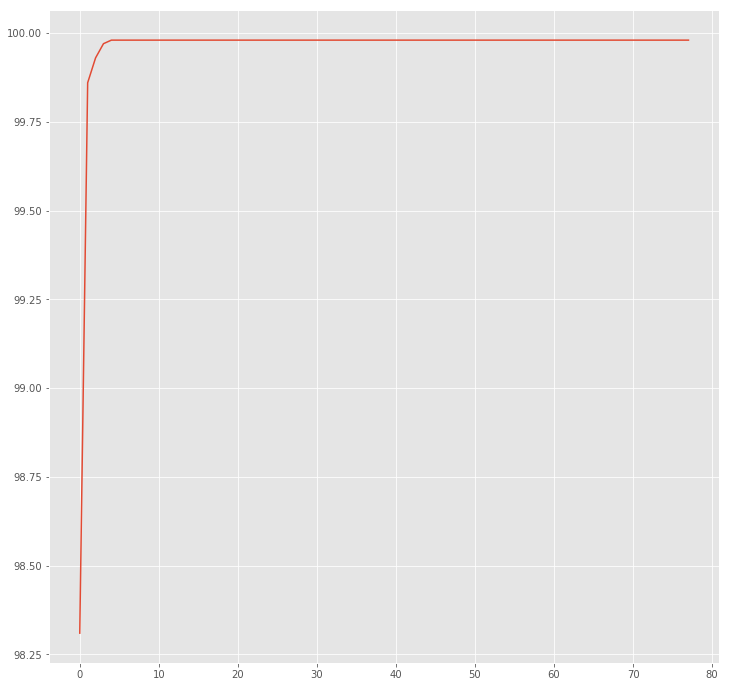

In [160]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

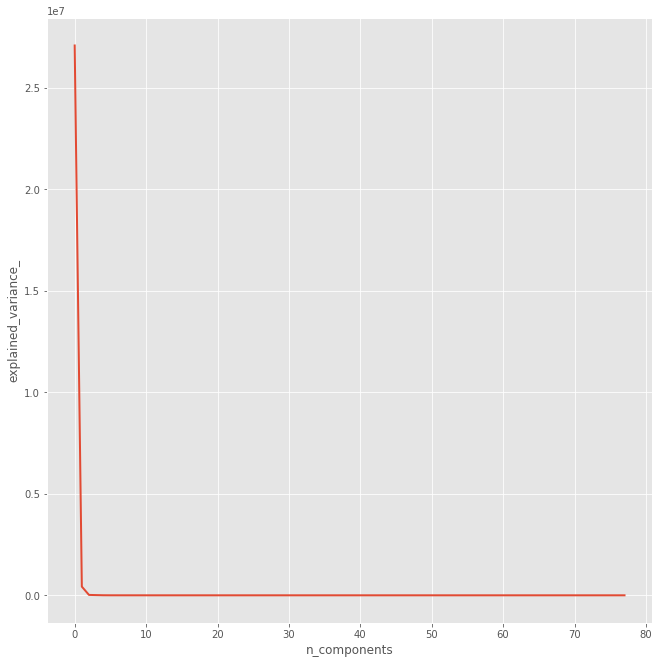

In [161]:
pca = PCA()
pca.fit(x_ss)
plt.figure(1)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [162]:
pca = PCA(n_components=5)
x_ss_pca =pca.fit_transform(x_ss)
type(x_ss_pca)

numpy.ndarray

In [163]:
print(x_ss_pca.shape)

(58316, 5)


In [164]:
split_index = int(df.shape[0]*.5)
x_train, x_test = x_ss_pca[:split_index], x_ss_pca[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
y_test = pd.Series(y_test.values)

(29158, 5) (29158, 5)
(29158,) (29158,)


In [165]:
# x_train, x_test, y_train, y_test = train_test_split(x, y)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Model

In [166]:
mom_cols = []
for mom_time in [1, 15, 30, 60, 120]:
    col = 'average_log_return_{}_sign'.format(mom_time)
    df[col] = df['log_returns'].rolling(mom_time).mean().apply(up_down) #the sign of the average returns of the last x candles
    mom_cols.append(col)
print(mom_cols)

['average_log_return_1_sign', 'average_log_return_15_sign', 'average_log_return_30_sign', 'average_log_return_60_sign', 'average_log_return_120_sign']


In [167]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [168]:
for mod in models:
    #print(mod.steps[1][1].__class__.__name__)
    print(mod.__class__.__name__)
    print(np.mean(cross_val_score(mod, x_ss_pca, y, cv=3, n_jobs=-1)))

LogisticRegression
0.525636117353
DecisionTreeClassifier
0.503824106924
RandomForestClassifier
0.503429709896
AdaBoostClassifier
0.520886453232
GradientBoostingClassifier
0.52242977602


In [169]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [170]:
for mod in models:
    mod.fit(x_train, y_train)

In [171]:
df.head()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,ADX,ADXR,APO,AROON_1,AROON_2,AROONOSC,BOP,CCI,CMO,DX,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,TRIX,ULTOSC,WILLR,BBANDS_1,BBANDS_2,BBANDS_3,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MAMA_1,MAMA_2,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,AD,ADOSC,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,ATR,NATR,TRANGE,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25,MAVP_30,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 01:28:00,27,1.137700,1.137740,1.137490,1.137490,0.000158,0.000158,0.000114,1.000000,1.000000,34.092111,32.306912,-0.000090,71.428571,100.000000,28.571429,0.840000,82.186235,3.032385,2.689146,-0.000121,-0.000150,0.000028,-0.000090,-0.000107,0.000017,-0.000116,-0.000143,0.000027,45.605976,24.251924,0.000526,0.000080,22.981742,0.000499,-0.007872,0.007032,0.000070,1.000070,100.007032,51.516192,63.500015,53.964970,90.697674,63.500015,100.000000,81.554074,-0.001485,58.057106,-9.302326,1.137747,1.137490,1.137233,1.137430,1.137689,1.137691,1.137697,1.137649,1.137413,1.137427,1.137520,1.137525,1.137310,1.137310,1.137649,1.137431,1.137417,1.137639,1.137571,50.535199,9.894053,-16.000000,23.014960,28.790415,-0.000220,0.000132,0.481607,0.960247,1,0.000155,0.013624,0.000250,1.137513,1.137462,1.137501,1.137569,1.137586,1.137649,1,nan,nan,nan,nan
2016-04-01 01:29:00,19,1.137830,1.137920,1.137720,1.137720,0.000114,0.000114,-0.000185,1.000000,0.000000,32.631716,31.392334,-0.000080,64.285714,100.000000,35.714286,0.550000,176.495726,11.643529,13.646588,-0.000089,-0.000137,0.000049,-0.000080,-0.000101,0.000021,-0.000085,-0.000131,0.000046,47.342813,21.864149,0.000489,0.000290,28.774612,0.000643,-0.006993,0.025494,0.000255,1.000255,100.025494,55.821765,90.384073,71.272737,85.000000,90.384073,100.000000,100.000000,-0.001480,62.327778,-14.754098,1.137926,1.137576,1.137226,1.137465,1.137698,1.137671,1.137701,1.137633,1.137434,1.137428,1.137575,1.137615,1.137319,1.137319,1.137633,1.137507,1.137476,1.137626,1.137582,52.435199,12.020606,3.000000,22.742972,25.634968,-0.000151,0.000367,0.432636,0.943425,1,0.000160,0.014031,0.000220,1.137683,1.137547,1.137516,1.137572,1.137597,1.137633,1,nan,nan,nan,nan
2016-04-01 01:30:00,23,1.137620,1.137800,1.137560,1.137800,-0.000185,-0.000185,0.000211,0.000000,1.000000,30.398917,30.196349,-0.000082,57.142857,92.857143,35.714286,-0.750000,82.914046,-3.296069,1.372522,-0.000079,-0.000126,0.000047,-0.000082,-0.000097,0.000014,-0.000076,-0.000120,0.000045,40.197529,26.170010,0.000614,0.000040,25.461358,0.000597,-0.007230,0.003516,0.000035,1.000035,100.003516,48.351966,75.232558,76.372216,50.000000,75.232558,64.198786,88.066262,-0.001471,57.326513,-49.180328,1.137942,1.137598,1.137254,1.137470,1.137693,1.137652,1.137698,1.137617,1.137527,1.137452,1.137575,1.137615,1.137343,1.137343,1.137617,1.137572,1.137490,1.137616,1.137582,40.935199,8.138686,-20.000000,22.447931,21.431181,0.000023,0.000343,0.365383,0.916580,1,0.000168,0.014726,0.000270,1.137717,1.137583,1.137516,1.137568,1.137601,1.137617,0,nan,nan,nan,nan
2016-04-01 01:31:00,24,1.137860,1.137900,1.137590,1.137590,0.000211,0.000211,-0.000105,1.000000,0.000000,28.721003,29.685499,-0.000069,50.000000,85.714286,35.714286,0.870968,140.888120,11.310673,6.908125,-0.000051,-0.000111,0.000060,-0.000069,-0.000092,0.000023,-0.000049,-0.000106,0.000057,47.966445,22.908462,0.000570,0.000390,26.308426,0.000654,-0.006035,0.034287,0.000343,1.000343,100.034287,55.655336,74.943503,80.186711,89.830508,74.943503,98.520786,87.573191,-0.001454,61.042235,-9.836066,1.137961,1.137706,1

In [172]:
print(x_train.shape, y_train.shape)
from keras.utils.np_utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
print(y_train_binary.shape)

(29158, 5) (29158,)
(29158, 2)


In [173]:
# available activation functions at:
# https://keras.io/activations/
# https://en.wikipedia.org/wiki/Activation_function
# options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'
# there are other ways to initialize the weights besides 'uniform', too 

model = Sequential()
num_neurons_in_layer = 50
num_inputs = x_train.shape[1]
num_classes = y_train_binary.shape[1]
model.add(Dense(input_dim=num_inputs, 
                 output_dim=num_neurons_in_layer, 
                 init='uniform', 
                 activation='tanh')) 
model.add(Dense(input_dim=num_neurons_in_layer, 
                 output_dim=num_neurons_in_layer, 
                 init='uniform', 
                 activation='tanh'))
model.add(Dense(input_dim=num_neurons_in_layer, 
                 output_dim=num_neurons_in_layer, 
                 init='uniform', 
                 activation='sigmoid'))
model.add(Dense(input_dim=num_neurons_in_layer, 
                 output_dim=num_classes,
                 init='uniform', 
                 activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"] ) # (keep)

/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5, activation="tanh", units=50, kernel_initializer="uniform")`
  
/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="tanh", units=50, kernel_initializer="uniform")`
/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="sigmoid", units=50, kernel_initializer="uniform")`
/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="softmax", units=2, kernel_initializer="uniform")`


In [174]:
model.fit(x_train, y_train_binary, epochs=100, batch_size=500, verbose=1,validation_split=0.1)

Train on 26242 samples, validate on 2916 samples
Epoch 1/100
26242/26242 [==============================] - 0s - loss: 0.6922 - acc: 0.5244 - val_loss: 0.6911 - val_acc: 0.5322
Epoch 2/100
26242/26242 [==============================] - 0s - loss: 0.6920 - acc: 0.5259 - val_loss: 0.6921 - val_acc: 0.5322
Epoch 3/100
26242/26242 [==============================] - 0s - loss: 0.6921 - acc: 0.5259 - val_loss: 0.6910 - val_acc: 0.5322
Epoch 4/100
26242/26242 [==============================] - 0s - loss: 0.6922 - acc: 0.5259 - val_loss: 0.6910 - val_acc: 0.5322
Epoch 5/100
26242/26242 [==============================] - 0s - loss: 0.6922 - acc: 0.5210 - val_loss: 0.6910 - val_acc: 0.5322
Epoch 6/100
26242/26242 [==============================] - 0s - loss: 0.6918 - acc: 0.5257 - val_loss: 0.6914 - val_acc: 0.5322
Epoch 7/100
26242/26242 [==============================] - 0s - loss: 0.6925 - acc: 0.5189 - val_loss: 0.6917 - val_acc: 0.5322
Epoch 8/100
26242/26242 [==============================

In [175]:
y_train_pred_nn = model.predict_classes(x_train, verbose=1)
y_test_pred_nn = model.predict_classes(x_test, verbose=1)
y_test_pred_proba_nn = model.predict_proba(x_test)
train_acc = np.sum(y_train == y_train_pred_nn, axis=0) / x_train.shape[0]
test_acc = np.sum(y_test == y_test_pred_nn, axis=0) / x_test.shape[0]
print('\n','train acc: {} test acc: {}'.format(train_acc, test_acc))

27744/29158 [===========================>..] - ETA: 0s
 train acc: 0.5265107346182866 test acc: 0.5253789697510117


In [176]:
xgb_params = {
    'objective': 'binary:logistic',
    'silent': 1,
    'eval_metric': 'error',
    'max_depth': 3
}

In [177]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'test')]
clf = xgb.train(xgb_params, d_train, 10000, watchlist, early_stopping_rounds=1000, verbose_eval=10)

[0]	train-error:0.468345	test-error:0.474038
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
[10]	train-error:0.458879	test-error:0.482989
[20]	train-error:0.449894	test-error:0.483126
[30]	train-error:0.443995	test-error:0.485527
[40]	train-error:0.437136	test-error:0.483812
[50]	train-error:0.431545	test-error:0.482578
[60]	train-error:0.428767	test-error:0.483607
[70]	train-error:0.425098	test-error:0.482852
[80]	train-error:0.417621	test-error:0.482749
[90]	train-error:0.414878	test-error:0.482612
[100]	train-error:0.410728	test-error:0.481686
[110]	train-error:0.408499	test-error:0.482132
[120]	train-error:0.404349	test-error:0.481823
[130]	train-error:0.397901	test-error:0.481103
[140]	train-error:0.393031	test-error:0.480829
[150]	train-error:0.38847	test-error:0.480966
[160]	train-error:0.386583	test-error:0.480314
[170]	train-error:0.382708	test-error:0.480486
[180]	train-error:0

In [178]:
xg_predict = clf.predict(d_test)
print(xg_predict.min(), xg_predict.max(), scs.describe(xg_predict))
xg_predict

0.00479572 0.99989 DescribeResult(nobs=29158, minmax=(0.0047957157, 0.99988997), mean=0.82805246, variance=0.044257388, skewness=-1.5097752809524536, kurtosis=1.3681526491508507)


array([ 0.48251078,  0.54866552,  0.43404689, ...,  0.99006432,
        0.97227919,  0.97595334], dtype=float32)

In [179]:
predict_df_cols = ['log_returns'] + mom_cols
prediction_df = df[predict_df_cols][split_index:]
print(type(prediction_df))
print(prediction_df.shape)
prediction_df.head(50)

<class 'pandas.core.frame.DataFrame'>
(29158, 6)


,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign
time,,,,,,
2016-05-02 06:59:00,0.000009,1,1.000000,0.000000,0.000000,0.000000
2016-05-02 07:00:00,-0.000471,0,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:01:00,-0.000201,0,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:02:00,-0.000070,0,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:03:00,-0.000105,0,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:04:00,-0.000105,0,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:05:00,0.000236,1,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:06:00,0.000201,1,0.000000,0.000000,0.000000,0.000000
2016-05-02 07:07:00,-0.000070,0,0.000000,0.000000,0.000000,0.000000


In [180]:
prediction_df['nn_prediction'] = y_test_pred_nn

In [181]:
prediction_df['xg_prediction'] = (xg_predict>=.5)*1

In [182]:
prediction_df['always_1'] = 1
prediction_df['always_0'] = 0

In [183]:
prediction_df.head()

,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign,nn_prediction,xg_prediction,always_1,always_0
time,,,,,,,,,,
2016-05-02 06:59:00,0.000009,1,1.000000,0.000000,0.000000,0.000000,1,0,1,0
2016-05-02 07:00:00,-0.000471,0,0.000000,0.000000,0.000000,0.000000,1,1,1,0
2016-05-02 07:01:00,-0.000201,0,0.000000,0.000000,0.000000,0.000000,1,0,1,0
2016-05-02 07:02:00,-0.000070,0,0.000000,0.000000,0.000000,0.000000,1,1,1,0
2016-05-02 07:03:00,-0.000105,0,0.000000,0.000000,0.000000,0.000000,1,0,1,0


In [184]:
for mod in prediction_df.columns[1:]:
    print(mod)
    y_pred = prediction_df[mod].values
    print('----------------------------')
    print('accuracy', accuracy_score(y_test, y_pred))
    print('----------------------------')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

average_log_return_1_sign
----------------------------
accuracy 0.48748199465
----------------------------
recall 0.511729726197
----------------------------
precision 0.511729726197
----------------------------
col_0        0     1
row_0               
0.000000  6383  7472
1.000000  7472  7831
----------------------------
             precision    recall  f1-score   support

        0.0       0.46      0.46      0.46     13855
        1.0       0.51      0.51      0.51     15303

avg / total       0.49      0.49      0.49     29158

----------------------------
average_log_return_15_sign
----------------------------
accuracy 0.48247479251
----------------------------
recall 0.47049598118
----------------------------
precision 0.507506872489
----------------------------
col_0     0.000000  1.000000
row_0                       
0.000000      6868      6987
1.000000      8103      7200
----------------------------
             precision    recall  f1-score   support

        0.0       0.

/home/applesauce/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/applesauce/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [185]:
for mod in models:
    #mod_name = mod.steps[1][1].__class__.__name__
    mod_name = mod.__class__.__name__
    print(mod_name)
    print('----------------------------')
    print('accuracy', mod.score(x_test, y_test))
    print('----------------------------')
    y_pred = mod.predict(x_test)
    prediction_df[mod_name] = y_pred
    y_pred = pd.Series(y_pred, name='pred')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

LogisticRegression
----------------------------
accuracy 0.493449482132
----------------------------
recall 0.211004378226
----------------------------
precision 0.544978902954
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000     11159      2696
1.000000     12074      3229
----------------------------
             precision    recall  f1-score   support

        0.0       0.48      0.81      0.60     13855
        1.0       0.54      0.21      0.30     15303

avg / total       0.51      0.49      0.45     29158

----------------------------
DecisionTreeClassifier
----------------------------
accuracy 0.517422319775
----------------------------
recall 0.640789387702
----------------------------
precision 0.53351468988
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000      5281      8574
1.000000      5497      9806
----------------------------
             precision    recall  f1-score   suppor

LogisticRegression 0.517781303652
DecisionTreeClassifier 0.510975711534
RandomForestClassifier 0.505862659329
AdaBoostClassifier 0.512791799326
GradientBoostingClassifier 0.510705967297


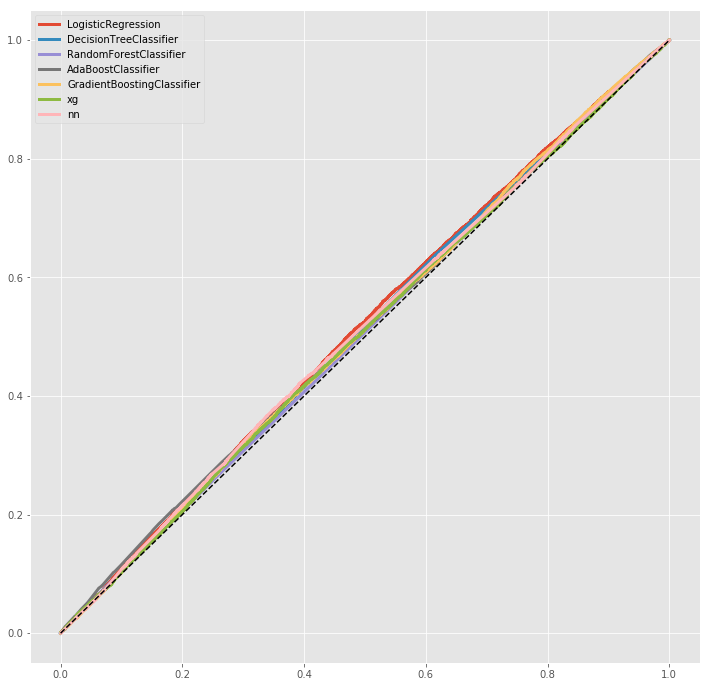

In [186]:
for classer in models:
    probas = classer.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    classer_name = classer.__class__.__name__
    #classer_name = classer.steps[1][1].__class__.__name__
    print(classer_name, roc_auc)
    plt.plot(fpr, tpr, lw=1, label=classer_name)
fpr, tpr, thresholds = roc_curve(y_test, xg_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='xg')
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='nn')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')

In [187]:
for classer in models[1:]:
    feat_impor = classer.feature_importances_
    x_feat = pd.DataFrame({'cols': [str(i) for i in range(x_ss_pca.shape[1])], 'feat_impo': feat_impor})
    classer_name = classer.__class__.__name__
    print(classer_name, '\n', x_feat.sort_values(by='feat_impo', ascending=False))

DecisionTreeClassifier 
   cols  feat_impo
2    2   0.205320
4    4   0.204997
3    3   0.196911
1    1   0.196750
0    0   0.196021
RandomForestClassifier 
   cols  feat_impo
2    2   0.201129
4    4   0.201058
0    0   0.199819
3    3   0.199043
1    1   0.198951
AdaBoostClassifier 
   cols  feat_impo
1    1   0.260000
2    2   0.220000
0    0   0.200000
3    3   0.160000
4    4   0.160000
GradientBoostingClassifier 
   cols  feat_impo
4    4   0.252369
2    2   0.197996
0    0   0.195071
3    3   0.181975
1    1   0.172589


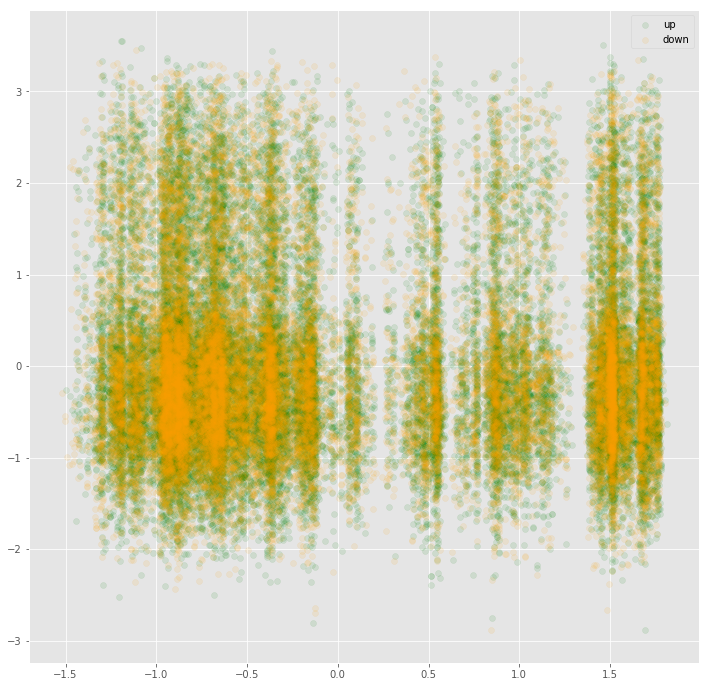

In [188]:
pca = PCA(n_components=2)
x_new = pca.fit_transform(x_ss_pca)
fig, ax = plt.subplots()
x_new_one = x_new[y==1]
x_new_zero = x_new[y==0]
ax.scatter(x_new_one[:,0], x_new_one[:,1], c='green', label='up', alpha=.1)
ax.scatter(x_new_zero[:,0], x_new_zero[:,1], c='orange', label='down', alpha=.1)
plt.legend(loc='best')

In [189]:
model_list = list(prediction_df.columns[1:])
for mod_col in model_list:
    prediction_df[mod_col] = prediction_df[mod_col].map({1:1, 0:-1}).shift(1)

In [190]:
prediction_df.head()

,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign,nn_prediction,xg_prediction,always_1,always_0,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
time,,,,,,,,,,,,,,,
2016-05-02 06:59:00,0.000009,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-05-02 07:00:00,-0.000471,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000
2016-05-02 07:01:00,-0.000201,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000
2016-05-02 07:02:00,-0.000070,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000
2016-05-02 07:03:00,-0.000105,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [191]:
model_returns = ['log_returns']
for mod_col in model_list:
    model_returns.append(mod_col+'_returns')
    prediction_df[mod_col+'_returns'] = prediction_df[mod_col] * prediction_df['log_returns']

In [192]:
prediction_df.head()

,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign,nn_prediction,xg_prediction,always_1,always_0,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,average_log_return_1_sign_returns,average_log_return_15_sign_returns,average_log_return_30_sign_returns,average_log_return_60_sign_returns,average_log_return_120_sign_returns,nn_prediction_returns,xg_prediction_returns,always_1_returns,always_0_returns,LogisticRegression_returns,DecisionTreeClassifier_returns,RandomForestClassifier_returns,AdaBoostClassifier_returns,GradientBoostingClassifier_returns
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-02 06:59:00,0.000009,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-05-02 07:00:00,-0.000471,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,-0.000471,-0.000471,0.000471,0.000471,0.000471,-0.000471,0.000471,-0.000471,0.000471,-0.000471,0.000471,0.000471,-0.000471,-0.000471
2016-05-02 07:01:00,-0.000201,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,0.000201,0.000201,0.000201,0.000201,0.000201,-0.000201,-0.000201,-0.000201,0.000201,-0.000201,-0.000201,0.000201,-0.000201,-0.000201
2016-05-02 07:02:00,-0.000070,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,0.000070,0.000070,0.000070,0.000070,0.000070,-0.000070,0.000070,-0.000070,0.000070,-0.000070,0.000070,0.000070,-0.000070,-0.000070
2016-05-02 07:03:00,-0.000105,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000105,0.000105,0.000105,0.000105,0.000105,-0.000105,-0.000105,-0.000105,0.000105,-0.000105,-0.000105,-0.000105,-0.000105,-0.000105


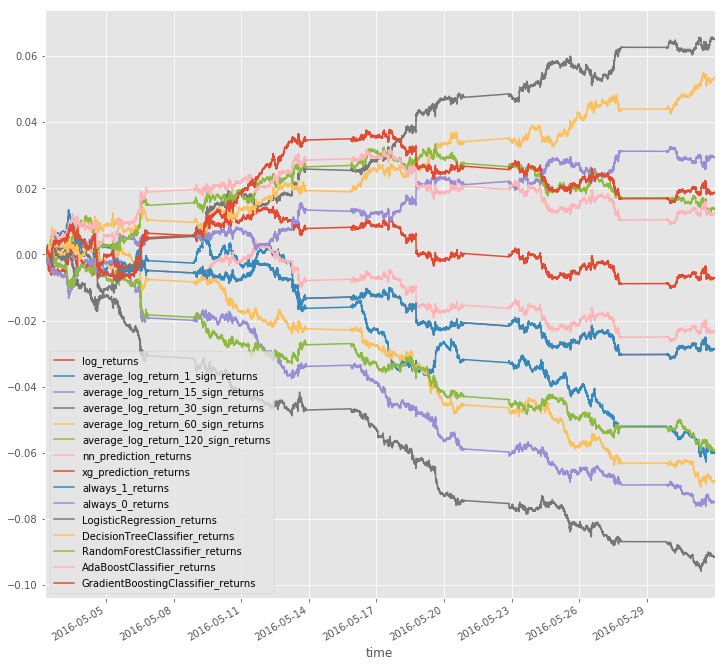

In [193]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

In [194]:
df.head(20)

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,ADX,ADXR,APO,AROON_1,AROON_2,AROONOSC,BOP,CCI,CMO,DX,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,TRIX,ULTOSC,WILLR,BBANDS_1,BBANDS_2,BBANDS_3,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MAMA_1,MAMA_2,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,AD,ADOSC,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,ATR,NATR,TRANGE,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25,MAVP_30,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 01:28:00,27,1.137700,1.137740,1.137490,1.137490,0.000158,0.000158,0.000114,1.000000,1.000000,34.092111,32.306912,-0.000090,71.428571,100.000000,28.571429,0.840000,82.186235,3.032385,2.689146,-0.000121,-0.000150,0.000028,-0.000090,-0.000107,0.000017,-0.000116,-0.000143,0.000027,45.605976,24.251924,0.000526,0.000080,22.981742,0.000499,-0.007872,0.007032,0.000070,1.000070,100.007032,51.516192,63.500015,53.964970,90.697674,63.500015,100.000000,81.554074,-0.001485,58.057106,-9.302326,1.137747,1.137490,1.137233,1.137430,1.137689,1.137691,1.137697,1.137649,1.137413,1.137427,1.137520,1.137525,1.137310,1.137310,1.137649,1.137431,1.137417,1.137639,1.137571,50.535199,9.894053,-16.000000,23.014960,28.790415,-0.000220,0.000132,0.481607,0.960247,1,0.000155,0.013624,0.000250,1.137513,1.137462,1.137501,1.137569,1.137586,1.137649,1,nan,nan,nan,nan
2016-04-01 01:29:00,19,1.137830,1.137920,1.137720,1.137720,0.000114,0.000114,-0.000185,1.000000,0.000000,32.631716,31.392334,-0.000080,64.285714,100.000000,35.714286,0.550000,176.495726,11.643529,13.646588,-0.000089,-0.000137,0.000049,-0.000080,-0.000101,0.000021,-0.000085,-0.000131,0.000046,47.342813,21.864149,0.000489,0.000290,28.774612,0.000643,-0.006993,0.025494,0.000255,1.000255,100.025494,55.821765,90.384073,71.272737,85.000000,90.384073,100.000000,100.000000,-0.001480,62.327778,-14.754098,1.137926,1.137576,1.137226,1.137465,1.137698,1.137671,1.137701,1.137633,1.137434,1.137428,1.137575,1.137615,1.137319,1.137319,1.137633,1.137507,1.137476,1.137626,1.137582,52.435199,12.020606,3.000000,22.742972,25.634968,-0.000151,0.000367,0.432636,0.943425,1,0.000160,0.014031,0.000220,1.137683,1.137547,1.137516,1.137572,1.137597,1.137633,1,nan,nan,nan,nan
2016-04-01 01:30:00,23,1.137620,1.137800,1.137560,1.137800,-0.000185,-0.000185,0.000211,0.000000,1.000000,30.398917,30.196349,-0.000082,57.142857,92.857143,35.714286,-0.750000,82.914046,-3.296069,1.372522,-0.000079,-0.000126,0.000047,-0.000082,-0.000097,0.000014,-0.000076,-0.000120,0.000045,40.197529,26.170010,0.000614,0.000040,25.461358,0.000597,-0.007230,0.003516,0.000035,1.000035,100.003516,48.351966,75.232558,76.372216,50.000000,75.232558,64.198786,88.066262,-0.001471,57.326513,-49.180328,1.137942,1.137598,1.137254,1.137470,1.137693,1.137652,1.137698,1.137617,1.137527,1.137452,1.137575,1.137615,1.137343,1.137343,1.137617,1.137572,1.137490,1.137616,1.137582,40.935199,8.138686,-20.000000,22.447931,21.431181,0.000023,0.000343,0.365383,0.916580,1,0.000168,0.014726,0.000270,1.137717,1.137583,1.137516,1.137568,1.137601,1.137617,0,nan,nan,nan,nan
2016-04-01 01:31:00,24,1.137860,1.137900,1.137590,1.137590,0.000211,0.000211,-0.000105,1.000000,0.000000,28.721003,29.685499,-0.000069,50.000000,85.714286,35.714286,0.870968,140.888120,11.310673,6.908125,-0.000051,-0.000111,0.000060,-0.000069,-0.000092,0.000023,-0.000049,-0.000106,0.000057,47.966445,22.908462,0.000570,0.000390,26.308426,0.000654,-0.006035,0.034287,0.000343,1.000343,100.034287,55.655336,74.943503,80.186711,89.830508,74.943503,98.520786,87.573191,-0.001454,61.042235,-9.836066,1.137961,1.137706,1

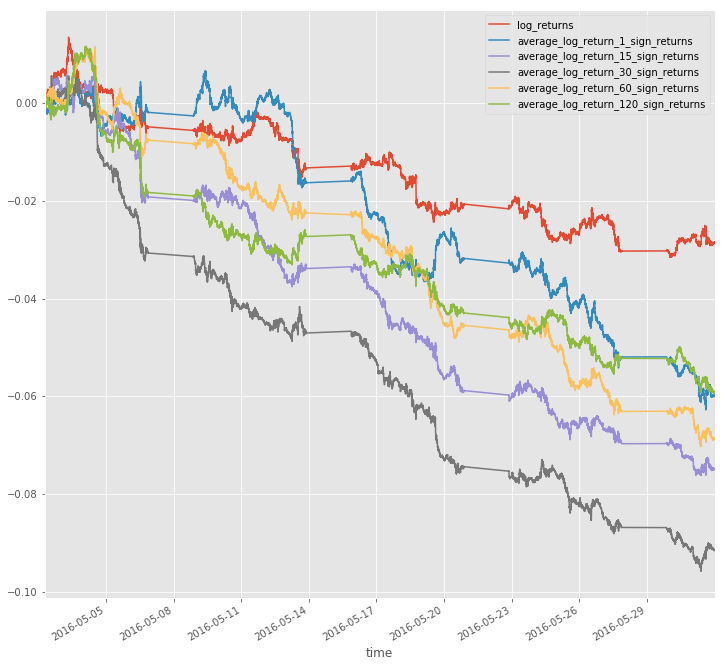

In [195]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns[:6]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

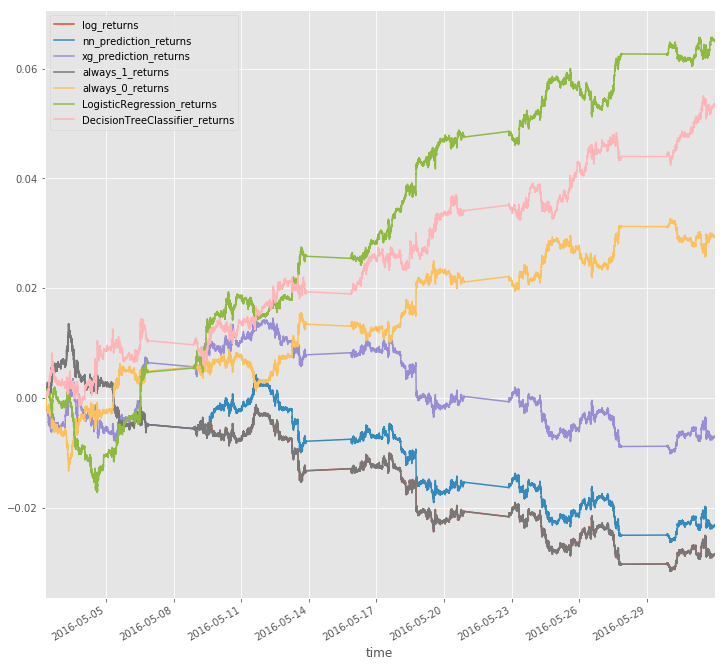

In [198]:
fig, axes = plt.subplots()
cum_returns = prediction_df[[model_returns[0]]+model_returns[6:12]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

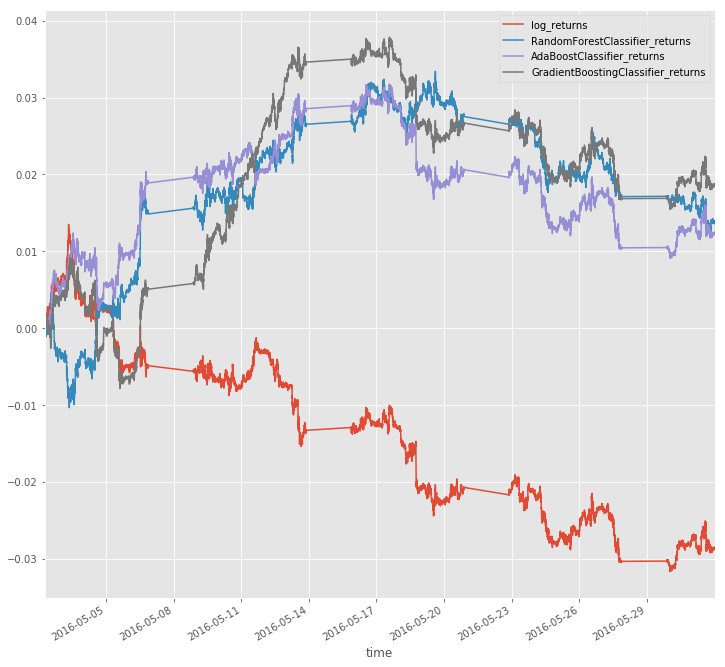

In [199]:
fig, axes = plt.subplots()
cum_returns = prediction_df[[model_returns[0]]+model_returns[12:]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')